In [1]:
using Plots
using Random
using Distributions

Random.seed!(1234);
rng = MersenneTwister(1234);
gr();

include("../kernel/kernel.jl")

predict

In [2]:
function create_toy_data(func, n_samples::Int64, std=1.0, domain=[0.0, 1.0])
    x = collect(range(domain[1], domain[2], length=n_samples));
    shuffle!(rng, x);
    noise = rand(Uniform(-std, std), n_samples);
    return x, func.(x) + noise
end

function sinusoidal(x)
    return sin.(2 * pi .* x)
end

sinusoidal (generic function with 1 method)

## 6.1 Dual Representation

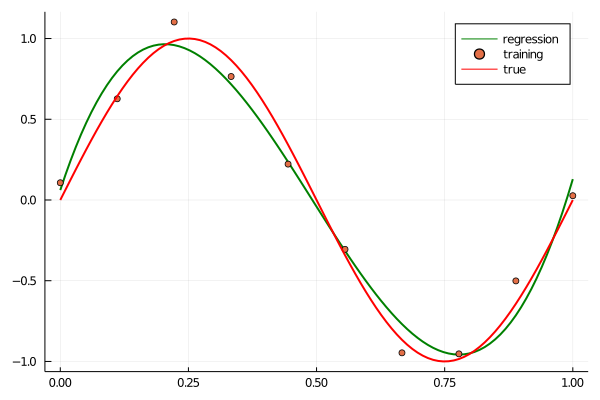

In [3]:
x_train, y_train = create_toy_data(sinusoidal, 10, 0.2);

x_train = reshape(x_train, 1, size(x_train)[1])
model = GaussianProcessRegressor(PolynomialKernel(3, 1.0), 1e10)
fitting(model, x_train, y_train);

x = reshape(collect(range(0.0, 1.0, length=100)), 1, 100);
y, y_sigmas = predict(model, x, true)

plot(x[1, :], y[1, :], lw=2, color="green", label="regression")
plot!(x_train[1, :], y_train, seriestype="scatter", label="training")
plot!(x[1, :], sin.(2 * pi .* x[1, :]), lw=2, color="red", label="true")

## 6.4 Gaussian Process

### 6.4.2 Gaussian process for regression

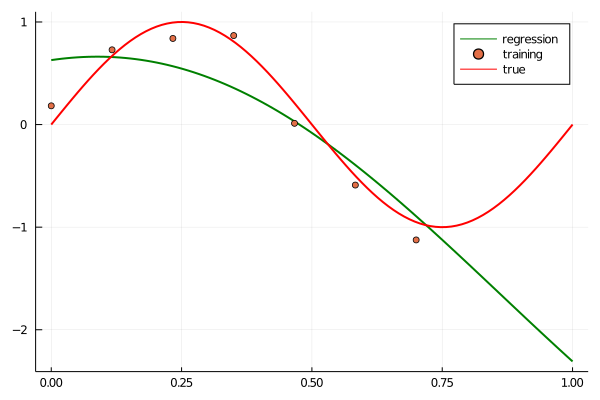

In [4]:
x_train, y_train = create_toy_data(sinusoidal, 7, 0.2, [0.0, 0.7]);
x_train = reshape(x_train, 1, size(x_train)[1])
model = GaussianProcessRegressor(RBFKernel([1.0, 1.0]), 100);
fitting(model, x_train, y_train)

x = reshape(collect(range(0.0, 1.0, length=100)), 1, 100);
y, y_sigmas = predict(model, x, true)

plot(x[1, :], y[1, :], lw=2, color="green", label="regression")
plot!(x_train[1, :], y_train, seriestype="scatter", label="training")
plot!(x[1, :], sin.(2 * pi .* x[1, :]), lw=2, color="red", label="true")